# Image Classification ML Assignment 

#### In this jupyter notebook, you will modify and run a machine learning model to classify humpback whale individuals. This script has several functions that are written for you, please do NOT modify any code unless it specifies to change it. 

#### Training the first model will take roughly 10 minutes. Although there are questions throughout this file, it is prudent to begin training your model before answering these questions. Once the model has begun training, explore the structure of the image folders, consider what each box of code is doing, and answer the questions.

In [1]:
## Importing packages - Please DO NOT alter this box ##
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data.sampler import WeightedRandomSampler

from captum.attr import IntegratedGradients
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

import torchvision
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

import os
import imageio
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm
from scipy.ndimage import binary_erosion
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

#import wandb #remove comment if you are using weights and biases
#import random #remove comment if you are using weights and biases

**What is the goal of transforming the data set?**

The transformation process facilitates the training of our model in many ways. The normalization step adjusts the pixel values of each image to have a specefic mean and standard deviation.The code also resizes the images to the required dimension by VGG. In addition, images were changed to PyTorch tensors format required for processing. 

In [2]:
images = "/projects/bgmp/shared/Bi625/ML_Assignment/Datasets/Humpback_ML_set/Humpback_ML_set"

In [3]:
transform = transforms.Compose([
            transforms.Resize([224,224]), # Resizing the image as the VGG only take 224 x 244 as input size
            transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalize the data, these are the values that ResNet suggests based on their training data (natural scences)
            transforms.RandomRotation(10),
            transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 1)),
    transforms.ColorJitter(brightness=0.05, contrast=0.05),
    transforms.RandomHorizontalFlip()])

The below code completes the image transformations as coded in the above box.

In [4]:
all_images = datasets.ImageFolder(images, transform )
print(len(all_images))
print(all_images)

334
Dataset ImageFolder
    Number of datapoints: 334
    Root location: /projects/bgmp/shared/Bi625/ML_Assignment/Datasets/Humpback_ML_set/Humpback_ML_set
    StandardTransform
Transform: Compose(
               Resize(size=[224, 224], interpolation=bilinear, max_size=None, antialias=True)
               RandomResizedCrop(size=(224, 224), scale=(0.9, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 1))
               ColorJitter(brightness=(0.95, 1.05), contrast=(0.95, 1.05), saturation=None, hue=None)
               RandomHorizontalFlip(p=0.5)
           )


The below code eastablishes the data split between training, validation, and testing.

In [5]:
train_size = int(0.7 * len(all_images))
val_size = int(0.15 * len(all_images))
test_size = len(all_images) - (train_size + val_size)
print(train_size, val_size, test_size)
assert train_size + val_size + test_size == len(all_images)

233 50 51


In [6]:
train_set, val_set, test_set = torch.utils.data.random_split(all_images, [train_size, val_size, test_size])

The below function is used to get weights for the image classes.

In [7]:
def _get_weights(subset,full_dataset):
    ys = np.array([y for _, y in subset])
    counts = np.bincount(ys)
    label_weights = 1.0 / counts
    weights = label_weights[ys]

    print("Number of images per class:")
    for c, n, w in zip(full_dataset.classes, counts, label_weights):
        print(f"\t{c}:\tn={n}\tweight={w}")
        
    return weights



The below function is used to randomly select dataset images to evaluate how the transformations altered the images.

In [8]:
def show_random_dataset_image(dataset):
    idx = np.random.randint(0, len(dataset))    # take a random sample
    img, mask = dataset[idx]                    # get the image and the nuclei masks
    f, axarr = plt.subplots(1, 2)               # make two plots on one figure
    axarr[0].imshow(img[0], cmap="gist_ncar")                     # show the image, cmap is the color map that the image is being shown in
    #axarr[1].imshow(mask[1])                    # show the masks
    _ = [ax.axis('off') for ax in axarr]        # remove the axes
    print('Image size is %s' % {img[0].shape})
    print(img.shape)
    plt.show()

**What is the difference between image size and torch image size?**

Image size shows the 2D size of one RGB channel, while the torch image size shows the tensor strucutre which includes the number of channels in addition to the dimensions.

Image size is {torch.Size([224, 224])}
torch.Size([3, 224, 224])


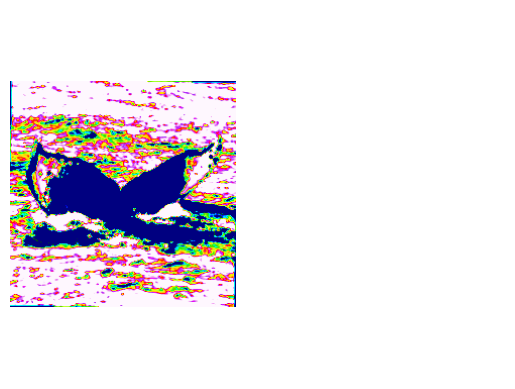

Image size is {torch.Size([224, 224])}
torch.Size([3, 224, 224])


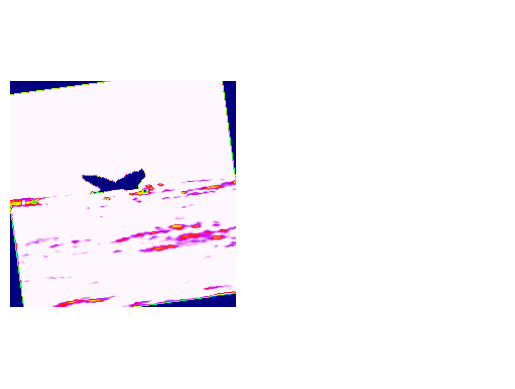

Image size is {torch.Size([224, 224])}
torch.Size([3, 224, 224])


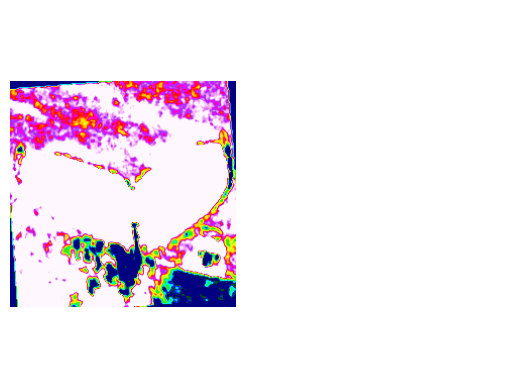

Image size is {torch.Size([224, 224])}
torch.Size([3, 224, 224])


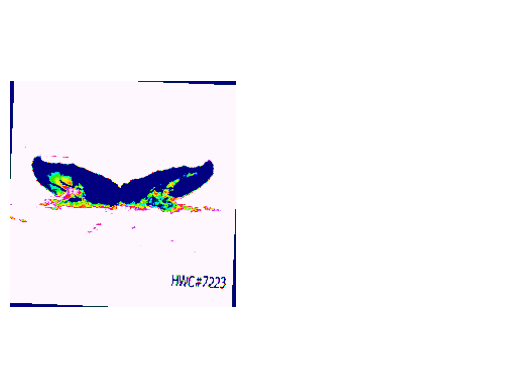

Image size is {torch.Size([224, 224])}
torch.Size([3, 224, 224])


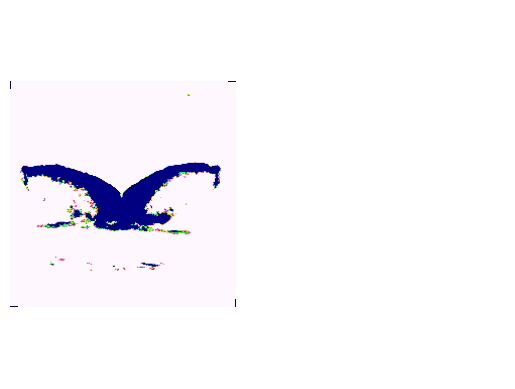

Image size is {torch.Size([224, 224])}
torch.Size([3, 224, 224])


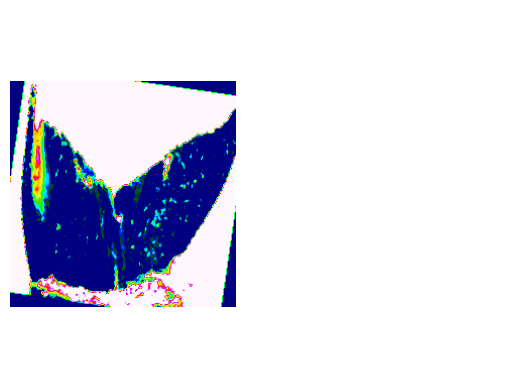

In [9]:
show_random_dataset_image(train_set)
show_random_dataset_image(train_set)
show_random_dataset_image(train_set)
show_random_dataset_image(train_set)


show_random_dataset_image(val_set)
show_random_dataset_image(test_set)

**Add a new transformation to the training data and discuss how it modifies the images.**

A new transformation that I addes is `transforms.RandomErasing`. It randomely selects a regtangular region of the image and replaces it with noise. It can help the model learn from a training set where some parts are obscured and so it will force the model to rely on different parts of the image. 

Image size is {torch.Size([224, 224])}
torch.Size([3, 224, 224])


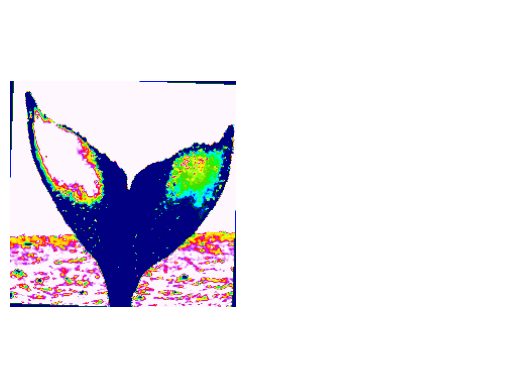

Image size is {torch.Size([224, 224])}
torch.Size([3, 224, 224])


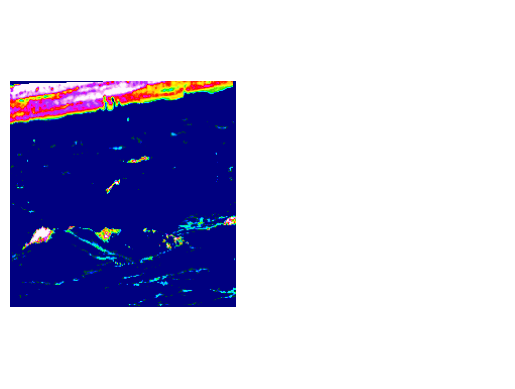

Image size is {torch.Size([224, 224])}
torch.Size([3, 224, 224])


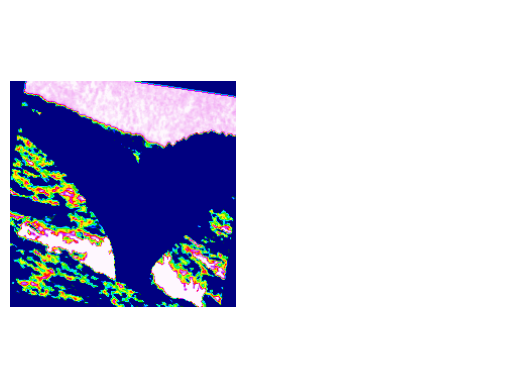

Image size is {torch.Size([224, 224])}
torch.Size([3, 224, 224])


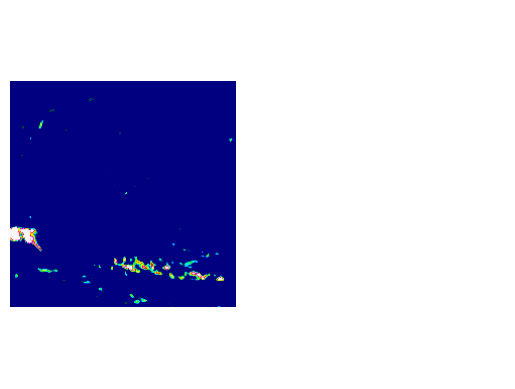

Image size is {torch.Size([224, 224])}
torch.Size([3, 224, 224])


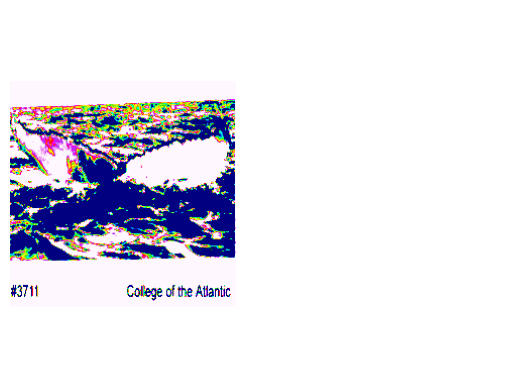

Image size is {torch.Size([224, 224])}
torch.Size([3, 224, 224])


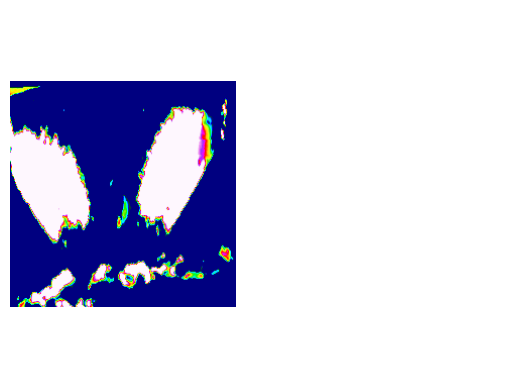

In [10]:
transform = transforms.Compose([
            transforms.Resize([224,224]), # Resizing the image as the VGG only take 224 x 244 as input size
            transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
            transforms.ToTensor(),
            transforms.RandomErasing(p=0.1, scale=(0.02, 0.2), ratio=(0.3, 2.1), value=0),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalize the data, these are the values that ResNet suggests based on their training data (natural scences)
            transforms.RandomRotation(10),
            transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 1)),
    transforms.ColorJitter(brightness=0.05, contrast=0.05),
    transforms.RandomHorizontalFlip()])

all_images = datasets.ImageFolder(images, transform )

train_set, val_set, test_set = torch.utils.data.random_split(all_images, [train_size, val_size, test_size])

show_random_dataset_image(train_set)
show_random_dataset_image(train_set)
show_random_dataset_image(train_set)
show_random_dataset_image(train_set)
show_random_dataset_image(val_set)
show_random_dataset_image(test_set)

In [11]:
train_weights = _get_weights(train_set,all_images)
train_sampler = WeightedRandomSampler(train_weights, len(train_weights))


Number of images per class:
	new_whale:	n=44	weight=0.022727272727272728
	w_0369a5c:	n=43	weight=0.023255813953488372
	w_23a388d:	n=58	weight=0.017241379310344827
	w_9b5109b:	n=41	weight=0.024390243902439025
	w_9c506f6:	n=47	weight=0.02127659574468085


**What is the class weight calculation by WeightedRandomSampler used for?**

<details>
  <summary>Hint</summary>
  
Check out this resource: https://towardsdatascience.com/demystifying-pytorchs-weightedrandomsampler-by-example-a68aceccb452 


This calculation addresses class imbalance in our dataset, without correcting for imbalance, a model can be overfitted to whales with more images. So this functions allows underrepresented whales (lower weights) to be selected more often, simulating a more balanced dataset. 

In [12]:
train_loader = DataLoader(train_set, batch_size=12, drop_last=True, sampler=train_sampler)
val_loader = DataLoader(val_set, batch_size=12, drop_last=True, shuffle=True)
test_loader = DataLoader(test_set, batch_size=12, drop_last=True, shuffle=True)

**What is resnet18?**

<details>
  <summary> Hint </summary>
  
 Check out this website: https://www.geeksforgeeks.org/resnet18-from-scratch-using-pytorch/

ResNet18 is a variant of the Residual Network (ResNet) architecture, which was introduced to address the vanishing gradient problem in deep neural networks. It will allow us to have deeper nextworks which will help in identifying more complex patterns in whales images.  

In [13]:
resnet18_model = torchvision.models.resnet18(weights = False, progress  = True, num_classes=5)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18_model.parameters(), lr=0.001)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet18_model.to(device)
print(f"Will use device {device} for training")


Will use device cpu for training


/projects/bgmp/shared/Bi625/ML_Assignment/Conda_Envs/HumpbackClassifierEnv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


The below functions are used to train, evaluate, and test the Machine Learning model.

In [14]:
def train(model,loss,train_dataloader):
    model.train()
    epoch_loss = 0
    num_batches = 0
    for x, y in tqdm(train_dataloader):

        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        y_pred = model(x)
        l = loss(y_pred, y)
        l.backward()
        optimizer.step()

        epoch_loss += l
        num_batches += 1

    return epoch_loss/num_batches

def evaluate(model, loss, dataloader):
    
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in tqdm(dataloader):

            x, y = x.to(device), y.to(device)

            logits = model(x)
            val_loss = loss(logits,y)
            
            probs = torch.nn.Softmax(dim=1)(logits)
            predictions = torch.argmax(probs, dim=1)

            correct += int(torch.sum(predictions == y).cpu().detach().numpy())
            total += len(y)

        accuracy = correct/total

    return accuracy, val_loss

def validate(model,loss, validation_dataloader):
    '''Evaluate prediction accuracy on the validation dataset.'''
    
    model.eval()
    return evaluate(model,loss,validation_dataloader)

def test(model,loss,test_dataloader):
    '''Evaluate prediction accuracy on the test dataset.'''
    
    model.eval() 
    return evaluate(model, loss,test_dataloader)


#### Start with 10 epochs, run the below model and consider the success of the model training. 

**What is your starting accuracy and final accuracy? Why is there a difference between the two?**

The starting accuracy is 0.16 at epoch 1. The model then learns to recognize fluke patterns from the training dataset, leading teh accuract to increase to 0.33 at epoch 7. It then drops again at the end but it stays higher than what we started with. 

In [ ]:
# wandb.init(
#     project="Humpback-classification-project",
#     name="Humpback-training-run-preset-hyperparameters",
#     config={"learning rate":0.001,
#         "architecture": "CNN",
#         "dataset": "Humpback",
#         "epochs":10}
# ) ### Remove comments if using weights and biases

###
step = 0
epochs = 10

validation_accuracy_list = []
validation_loss_list = []

for epoch in range(epochs+1):
    while step < epoch: 
    
        epoch_loss = train(resnet18_model,loss_fn,train_loader)
        print(f"epoch {epoch}, training loss={epoch_loss}")
    
        validation_accuracy, validation_loss = validate(resnet18_model, loss_fn,val_loader)
        validation_accuracy_list.append(validation_accuracy)
        validation_loss_list.append(validation_loss)
        print(f"epoch {epoch}, validation accuracy={validation_accuracy}")
        
        # log metrics to wandb - remove comments if using weights and biases
        #wandb.log({"validation_accuracy": validation_accuracy, "validation_loss": validation_loss, "epoch_loss":epoch_loss})

        step += 1

plt.plot(range(10), validation_accuracy_list, color = "magenta")
plt.xlabel("Epoch number")
plt.ylabel("Valiation accuracy")
plt.show()  

plt.plot(range(10), validation_loss_list, color = "purple")
plt.xlabel("Epoch number")
plt.ylabel("Valiation loss")
plt.show()  

#wandb.finish() #remove comments if using weights and biases


100%|██████████| 19/19 [00:26<00:00,  1.40s/it]


epoch 1, training loss=1.9636690616607666


100%|██████████| 4/4 [00:01<00:00,  2.68it/s]


epoch 1, validation accuracy=0.25


100%|██████████| 19/19 [00:25<00:00,  1.37s/it]


epoch 2, training loss=1.5720230340957642


100%|██████████| 4/4 [00:01<00:00,  3.00it/s]


epoch 2, validation accuracy=0.1875


100%|██████████| 19/19 [00:26<00:00,  1.38s/it]


epoch 3, training loss=1.5815975666046143


100%|██████████| 4/4 [00:01<00:00,  3.05it/s]


epoch 3, validation accuracy=0.2916666666666667


100%|██████████| 19/19 [00:26<00:00,  1.39s/it]


epoch 4, training loss=1.5754921436309814


100%|██████████| 4/4 [00:01<00:00,  3.05it/s]


epoch 4, validation accuracy=0.22916666666666666


100%|██████████| 19/19 [00:26<00:00,  1.39s/it]


epoch 5, training loss=1.475358009338379


100%|██████████| 4/4 [00:01<00:00,  3.01it/s]


epoch 5, validation accuracy=0.3333333333333333


100%|██████████| 19/19 [00:26<00:00,  1.39s/it]


epoch 6, training loss=1.4376609325408936


100%|██████████| 4/4 [00:01<00:00,  3.04it/s]


epoch 6, validation accuracy=0.16666666666666666


 21%|██        | 4/19 [00:05<00:20,  1.34s/it]

After running the model and calculating the overall accuracy, we can examine the data via a confusion matrix which highlights the accuracy by class.

In [ ]:
# predict the test dataset
def predict(model, dataset):
    dataset_prediction = []
    dataset_groundtruth = []
    model = model
    with torch.no_grad():
        for x, y_true in dataset:
            inp = x[None]
            y_pred = model(inp)
            dataset_prediction.append(y_pred.argmax().cpu().numpy())
            dataset_groundtruth.append(y_true)
    
    return np.array(dataset_prediction), np.array(dataset_groundtruth)
            
    # create seaborn heatmap with required labels
    ax=sns.heatmap(cm, annot=annot, fmt='', vmax=30, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
    ax.set_title(title)

# Plot confusion matrix 
# orginally from Runqi Yang; 
# see https://gist.github.com/hitvoice/36cf44689065ca9b927431546381a3f7
def cm_analysis(y_true, y_pred, title, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    labels = ['new_whale','w_0369a5c', 'w_23a388d', 'w_9b5109b', 'w_9c506f6']
    cm = confusion_matrix(y_true, y_pred)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
                              
    x_axis_labels = ['new_whale','w_0369a5c', 'w_23a388d', 'w_9b5109b', 'w_9c506f6'] # labels for x-axis
    y_axis_labels = ['new_whale','w_0369a5c', 'w_23a388d', 'w_9b5109b', 'w_9c506f6'] # labels for y-axis
    ax=sns.heatmap(cm, annot=annot, fmt='', vmax=30, xticklabels=x_axis_labels, yticklabels=y_axis_labels, cmap = "viridis")
    ax.set_title(title)

## This plot only contains the test set of data
## The test set of data has not been seen by the model yet
y_pred, y_true = predict(resnet18_model, test_set)
cm_analysis(y_true, y_pred, "Confusion matrix")

Since the dataset is small, we can also manually look at the true and predicted classifications for our test dataset. 

In [ ]:
test_pred, test_true = predict(resnet18_model, test_set)
print(test_pred)
print(test_true)

### What features did the model use to make decisions?

Based on the confusion matrices and validation loss, it is clear that the model is learning. To determine the features that are involved in decision making, there are a few possible approaches. Two options are shown below, integrated gradients and CycleGAN. 

#### Understanding feature importance using Integrated Gradients

Integrated gradients is an attribution method. Attribution methods score the input data based on the prediction that the model makes using scores for each feature. The gradient is the signal that tells the network how much to increase or decrease a certain weight in the network during backpropogation. These gradients are overlaid onto the images to showcase the regions on the images that influence the weights.

**Run the below code. Does the integrated gradient show what types of features the model used to classify the images? What have you learned from it?**

Yes. The overlaid gradients highlight specific regions of the whale’s fluke, where these areas are key to the model’s decision-making process. Red pixels are those that push the model to the wrong prediction, while green areas contribute to the correct prediction. It seems like the upper part of the fluke is the most important region used by the model to classify these images. 


In [ ]:
def visualize_ig(idx, 
                 _train_dataset=train_set, 
                 _test_dataset=test_set):
        
    # Get corresponding input and target tensors:
    input_tensor = _test_dataset[idx][0].unsqueeze(0)
    input_tensor.requires_grad = True
    target = _test_dataset[idx][1]
    
    # We will use the IntegratedGradients algorithm:
    algorithm = IntegratedGradients(resnet18_model)
    
    # First we clear the gradients from the model:
    resnet18_model.zero_grad()
    
    # Run attribution:
    attr_ig, delta = algorithm.attribute(input_tensor,
                                          target=target,
                                          baselines=input_tensor * 0,
                                          return_convergence_delta=True
                                        )
    
    # Integrated Gradients:
    attr_ig = np.transpose(attr_ig[0].cpu().detach().numpy(), (1, 2, 0))
    
    # Original image:
    original_image = np.transpose((_test_dataset[idx][0].detach().numpy() * 0.5) + 0.5, (1, 2, 0))
    
    print("Annotated Whale Individual", test_true[idx])
    plt.imshow(original_image)
    
    
    print("Predicted Whale Individual", test_pred[idx])


    # This visualises the attribution of labels to 
    viz.visualize_image_attr(attr_ig, 
                             original_image, 
                             method="blended_heat_map",
                             sign="all",
                             show_colorbar=True, 
                             title="Overlayed Integrated Gradients")

visualize_ig(0)

visualize_ig(8)

visualize_ig(20)

visualize_ig(32)

## Code and Explore! 

Now that you have a sense for how to train a machine learning model, your task is to improve the success of our classification model.

**In two separate training events, make one (or more) modifications to the model training process, re-train the model, and report out your changes and whether they increased model accuracy. Why did you chose your particular change (curiousity, hypothesis, ect.)? Do you have ideas why your modifications were/were not successful?**

Types of changes that you can make include changing the model (different pre-made model architecture or create your own model!), the number of epochs, the optimizer, loss function, learning rate, batch size, image transformations, and more. If you decide to change any lines of code that are not in the below box, please add them to the box (DO NOT MODIFY ANY CODE ABOVE THIS MARKDOWN BOX). 

If your changes are ambitious, the code may take hours to run. If this is the case, please consider turning this notebook into a python script and running it via sBATCH. 

**Please note, you will NOT be graded by the success of your classifiers! It is okay if you are unable to improve the accuracy of the classifier**

#### Your Model 1

*Describe your changes to the model (either changing something about the model, a hyperparameter, or something else), why you selected those changes, and their success here*

In [ ]:
train_loader = DataLoader(train_set, batch_size=12, drop_last=True, sampler=train_sampler)
val_loader = DataLoader(val_set, batch_size=12, drop_last=True, shuffle=True)
test_loader = DataLoader(test_set, batch_size=12, drop_last=True, shuffle=True)

resnet18_model = torchvision.models.resnet18(weights = False, progress  = True, num_classes=5)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18_model.parameters(), lr=0.001) #possibly update

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet18_model.to(device)
print(f"Will use device {device} for training")

# wandb.init(
#     project="Humpback-classification-project",
#     name="Humpback-training-run-student-selected-hyperparameters", ##update this with your first initial and last name
#     config={"learning rate":.001, # possibly update
#         "architecture": "CNN",
#         "dataset": "Humpback",
#         "epochs": 10}  # possibly update
# ) ##Remove comments if using weights and biases



step = 0
epochs = 15 # possibly update

validation_accuracy_list = []
validation_loss_list = []

for epoch in range(epochs+1):
    while step < epoch: 
    
        epoch_loss = train(resnet18_model,loss_fn,train_loader)
        print(f"epoch {epoch}, training loss={epoch_loss}")
    
        validation_accuracy, validation_loss = validate(resnet18_model, loss_fn,val_loader)
        validation_accuracy_list.append(validation_accuracy)
        validation_loss_list.append(validation_loss)
        print(f"epoch {epoch}, validation accuracy={validation_accuracy}")
    
        # log metrics to wandb - remove comments if using weights and biases
        #wandb.log({"validation_accuracy": validation_accuracy, "validation_loss": validation_loss, "epoch_loss":epoch_loss})

        step += 1


#wandb.finish() #remove comments if using weights and biases

plt.plot(range(15), validation_accuracy_list, color = "magenta")
plt.xlabel("Epoch number")
plt.ylabel("Valiation accuracy")
plt.show()  

plt.plot(range(15), validation_loss_list, color = "purple")
plt.xlabel("Epoch number")
plt.ylabel("Valiation loss")
plt.show()  

y_pred, y_true = predict(resnet18_model, test_set)
cm_analysis(y_true, y_pred, "Confusion matrix")

## Integrated gradient 
visualize_ig(0)
visualize_ig(8)
visualize_ig(20)
visualize_ig(32)

#### Your Model 2

*Describe your changes to the model training process (either changing something about the model, a hyperparameter, or something else), why you selected those changes, and their success here*

In [ ]:
train_loader = DataLoader(train_set, batch_size=16, drop_last=True, sampler=train_sampler)
val_loader = DataLoader(val_set, batch_size=16, drop_last=True, shuffle=True)
test_loader = DataLoader(test_set, batch_size=16, drop_last=True, shuffle=True)

resnet18_model = torchvision.models.resnet18(weights = False, progress  = True, num_classes=5)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18_model.parameters(), lr=0.001) #possibly update

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet18_model.to(device)
print(f"Will use device {device} for training")

# wandb.init(
#     project="Humpback-classification-project",
#     name="Humpback-training-run-student-selected-hyperparameters", ##update this with your first initial and last name
#     config={"learning rate":.001, # possibly update
#         "architecture": "CNN",
#         "dataset": "Humpback",
#         "epochs": 10}  # possibly update
# ) ##Remove comments if using weights and biases



step = 0
epochs = 10 # possibly update

validation_accuracy_list = []
validation_loss_list = []

for epoch in range(epochs+1):
    while step < epoch: 
    
        epoch_loss = train(resnet18_model,loss_fn,train_loader)
        print(f"epoch {epoch}, training loss={epoch_loss}")
    
        validation_accuracy, validation_loss = validate(resnet18_model, loss_fn,val_loader)
        validation_accuracy_list.append(validation_accuracy)
        validation_loss_list.append(validation_loss)
        print(f"epoch {epoch}, validation accuracy={validation_accuracy}")
    
        # log metrics to wandb - remove comments if using weights and biases
        #wandb.log({"validation_accuracy": validation_accuracy, "validation_loss": validation_loss, "epoch_loss":epoch_loss})

        step += 1


#wandb.finish() #remove comments if using weights and biases

plt.plot(range(10), validation_accuracy_list, color = "magenta")
plt.xlabel("Epoch number")
plt.ylabel("Valiation accuracy")
plt.show()  

plt.plot(range(10), validation_loss_list, color = "purple")
plt.xlabel("Epoch number")
plt.ylabel("Valiation loss")
plt.show()  

y_pred, y_true = predict(resnet18_model, test_set)
cm_analysis(y_true, y_pred, "Confusion matrix")

## Integrated gradient 
visualize_ig(0)
visualize_ig(8)
visualize_ig(20)
visualize_ig(32)